# Loan Predictions

### Importing Libraries

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
from pandarallel import pandarallel
warnings.filterwarnings('ignore')
pandarallel.initialize(nb_workers = 6,progress_bar = True)
from sklearn.model_selection import train_test_split


%matplotlib inline

/Users/achintya16/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
#Loading Column Names
meta = pd.read_csv('Metadata.csv')   

In [3]:
cols = pd.read_csv('Data for Cleaning & Modeling.csv', names = meta['Definition'])
cols = cols.iloc[1:]

In [4]:
#Replacing column names in cols dataframe with meta dataframe
df = cols

In [5]:
df.head()

,Interest Rate,Unique id loan.,Borrower id,Loan amount requested,Loan amount funded,Investor-funded portion of loan,Number of payments (36 or 60),Loan grade,Loan subgrade,Employer or job title (self-filled),...,Date the borrower's earliest reported credit line was opened,Inquiries by creditors during the past 6 months.,Months since the borrower's last delinquency.,Months since the last public record.,Open credit lines in the borrower's credit file.,Derogatory public records,Total credit revolving balance,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.",The total number of credit lines currently in the borrower's credit file,"The initial listing status of the loan. Possible values are ‰ÛÒ W, F"
1,11.89%,54734,80364,"$25,000","$25,000","$19,080",36 months,B,B4,NaN,...,Feb-94,0,NaN,NaN,10,0,28854,52.10%,42,f
2,10.71%,55742,114426,"$7,000","$7,000",$673,36 months,B,B5,CNN,...,Oct-00,0,NaN,NaN,7,0,33623,76.70%,7,f
3,16.99%,57167,137225,"$25,000","$25,000","$24,725",36 months,D,D3,Web Programmer,...,Jun-00,0,41,NaN,10,0,19878,66.30%,17,f
4,13.11%,57245,138150,"$1,200","$1,200","$1,200",36 months,C,C2,city of beaumont texas,...,Jan-85,0,64,NaN,5,0,2584,40.40%,31,f
5,13.57%,57416,139635,"$10,800","$10,800","$10,692",36 months,C,C3,State Farm Insurance,...,Dec-96,1,58,NaN,14,0,3511,25.60%,40,f


In [6]:
df.shape

(400000, 32)

In [7]:
df.isna().sum()

Interest Rate                                                                                                                  61010
Unique id loan.                                                                                                                    1
Borrower id                                                                                                                        1
Loan amount requested                                                                                                              1
Loan amount funded                                                                                                                 1
Investor-funded portion of loan                                                                                                    1
Number of payments (36 or 60)                                                                                                      1
Loan grade                                                           

<Axes: >

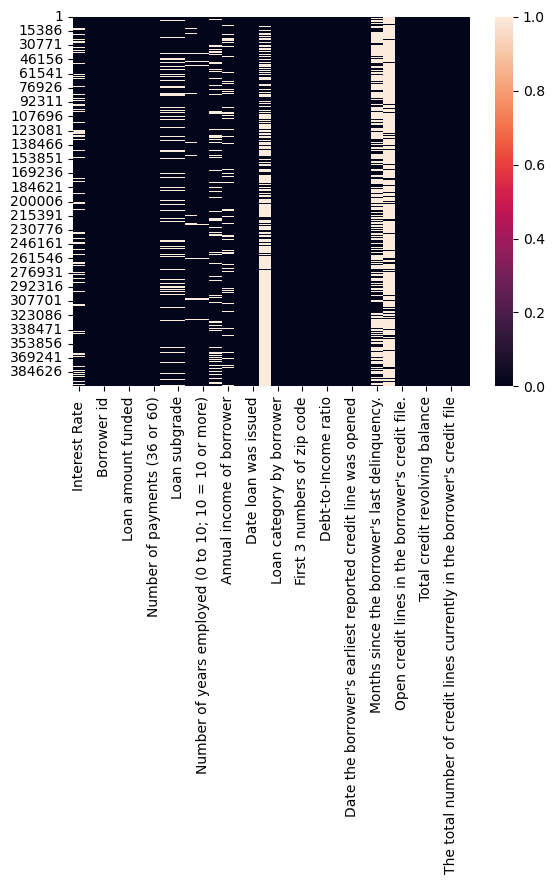

In [8]:
sns.heatmap(df.isnull())

### Conversion

In [9]:
# Dropping Irrelevant Columns 

df.drop(['Loan subgrade', 'Unique id loan.','Borrower id'], axis = 1, inplace = True)

In [10]:
# Converting object to numeric values 

df['Interest Rate '] = df['Interest Rate '].str.replace('%','').astype(float)
df['Loan amount requested'] = df['Loan amount requested'].str.replace('$','').str.replace(',','').astype('float')
df['Loan amount funded'] = df['Loan amount funded'].str.replace('$','').str.replace(',','').astype('float')
df['Investor-funded portion of loan'] = df['Investor-funded portion of loan'].str.replace('$', '').str.replace(',','').astype('float')
df['Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.'] =  df['Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.'].str.replace('%','').astype('float')
df['Date loan was issued'] = pd.to_datetime(df['Date loan was issued'], format='%b-%y')
df['Date the borrower\'s earliest reported credit line was opened'] = pd.to_datetime(df['Date the borrower\'s earliest reported credit line was opened'], format = '%b-%y')
df['Annual income of borrower'] = df['Annual income of borrower'].astype(float)
df['Debt-to-Income ratio'] = df['Debt-to-Income ratio'].astype(float)
df['The total number of credit lines currently in the borrower\'s credit file'] = df['The total number of credit lines currently in the borrower\'s credit file'].astype(float)
df['Total credit revolving balance'] = df['Total credit revolving balance'].astype(float)
df['Open credit lines in the borrower\'s credit file.'] = df['Open credit lines in the borrower\'s credit file.'].astype(float)
df['Derogatory public records'] = df['Derogatory public records'].astype(float)
df['Past-due incidences of delinquency in the borrower\'s credit file for the past 2 years'] = df['Past-due incidences of delinquency in the borrower\'s credit file for the past 2 years'].astype(float)
df['Inquiries by creditors during the past 6 months.'] = df["Inquiries by creditors during the past 6 months."].astype(float)

In [11]:
# Converting categorical features to numerical 
df['Term Length'] = df['Number of payments (36 or 60)'].map({' 36 months': 0, ' 60 months': 1 })

#Dropping Number of payments (36 or 60) columns to avoid collinearity 
df.drop('Number of payments (36 or 60)', axis=1, inplace = True)

In [12]:
# Performing Ordinal encoding on Income Verified 

df['Income verified, not verified, or income source was verified'] = df['Income verified, not verified, or income source was verified'].map(
{'VERIFIED - income': 5 , 'not verified': 0 , 'VERIFIED - income source': 5})


In [13]:
# Converting Categorical Loan Column to Numerical Column 
df['Loan category by borrower'] = df['Loan category by borrower'].map({
    'debt_consolidation': 0, 'credit_card': 1, 'car': 2, 'home_improvement': 3,
    'small_business': 4, 'major_purchase': 5, 'moving': 6, 'other': 7, 'house': 8,
    'vacation': 9, 'educational': 10, 'wedding': 11, 'medical': 12,
    'renewable_energy': 13})

### Treating NULL Values 

In [14]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [15]:
missing_values_table(df)

Your selected dataframe has 29 columns.
There are 29 columns that have missing values.


,Missing Values,% of Total Values
Months since the last public record.,348845,87.2
Reason for loan by borrower,276442,69.1
Months since the borrower's last delinquency.,218802,54.7
Home ownership status,61361,15.3
Loan grade,61270,15.3
Annual income of borrower,61028,15.3
Interest Rate,61010,15.3
Employer or job title (self-filled),23986,6.0
Number of years employed (0 to 10; 10 = 10 or more),17538,4.4
"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.",267,0.1


In [16]:
#Looking at grade and verifying it with interest rate(Amount of money funded, average interest rate)
table = pd.pivot_table(df, values = ['Interest Rate ', 'Loan amount funded'], columns= 'Loan grade')

In [17]:
table

Loan grade,A,B,C,D,E,F,G
Interest Rate,7.577277,11.608589,14.794494,17.717614,20.655374,23.606236,25.141532
Loan amount funded,13219.260525,12935.486584,14232.084966,15031.348771,17633.686026,18441.562756,21294.260906


<Axes: >

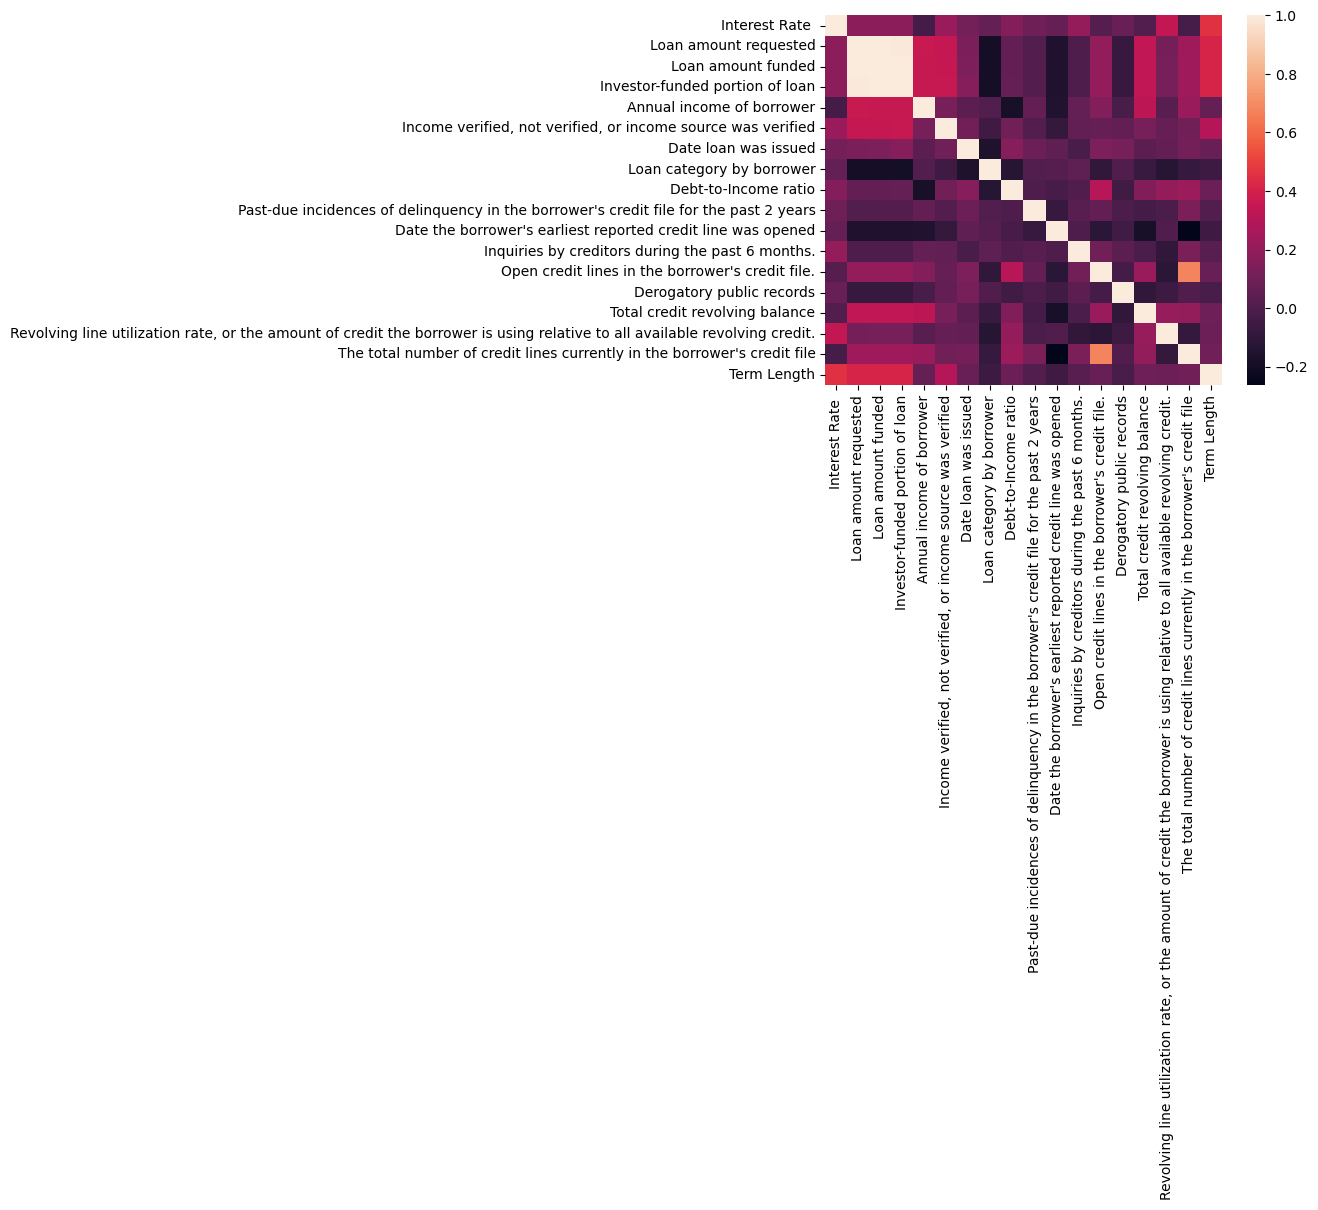

In [18]:
#Correlation of numerical values 
sns.heatmap(df.select_dtypes(exclude=['object']).corr())

In [19]:
#dropping Columns having more than 50% missing values
df.drop(['Months since the last public record.', 'Reason for loan by borrower', "Months since the borrower's last delinquency."], axis = 1, inplace = True)

#dropping Columns to avoid MultiCollinearity 
df.drop(['Loan amount requested', "Investor-funded portion of loan"], axis = 1, inplace = True)


<Axes: >

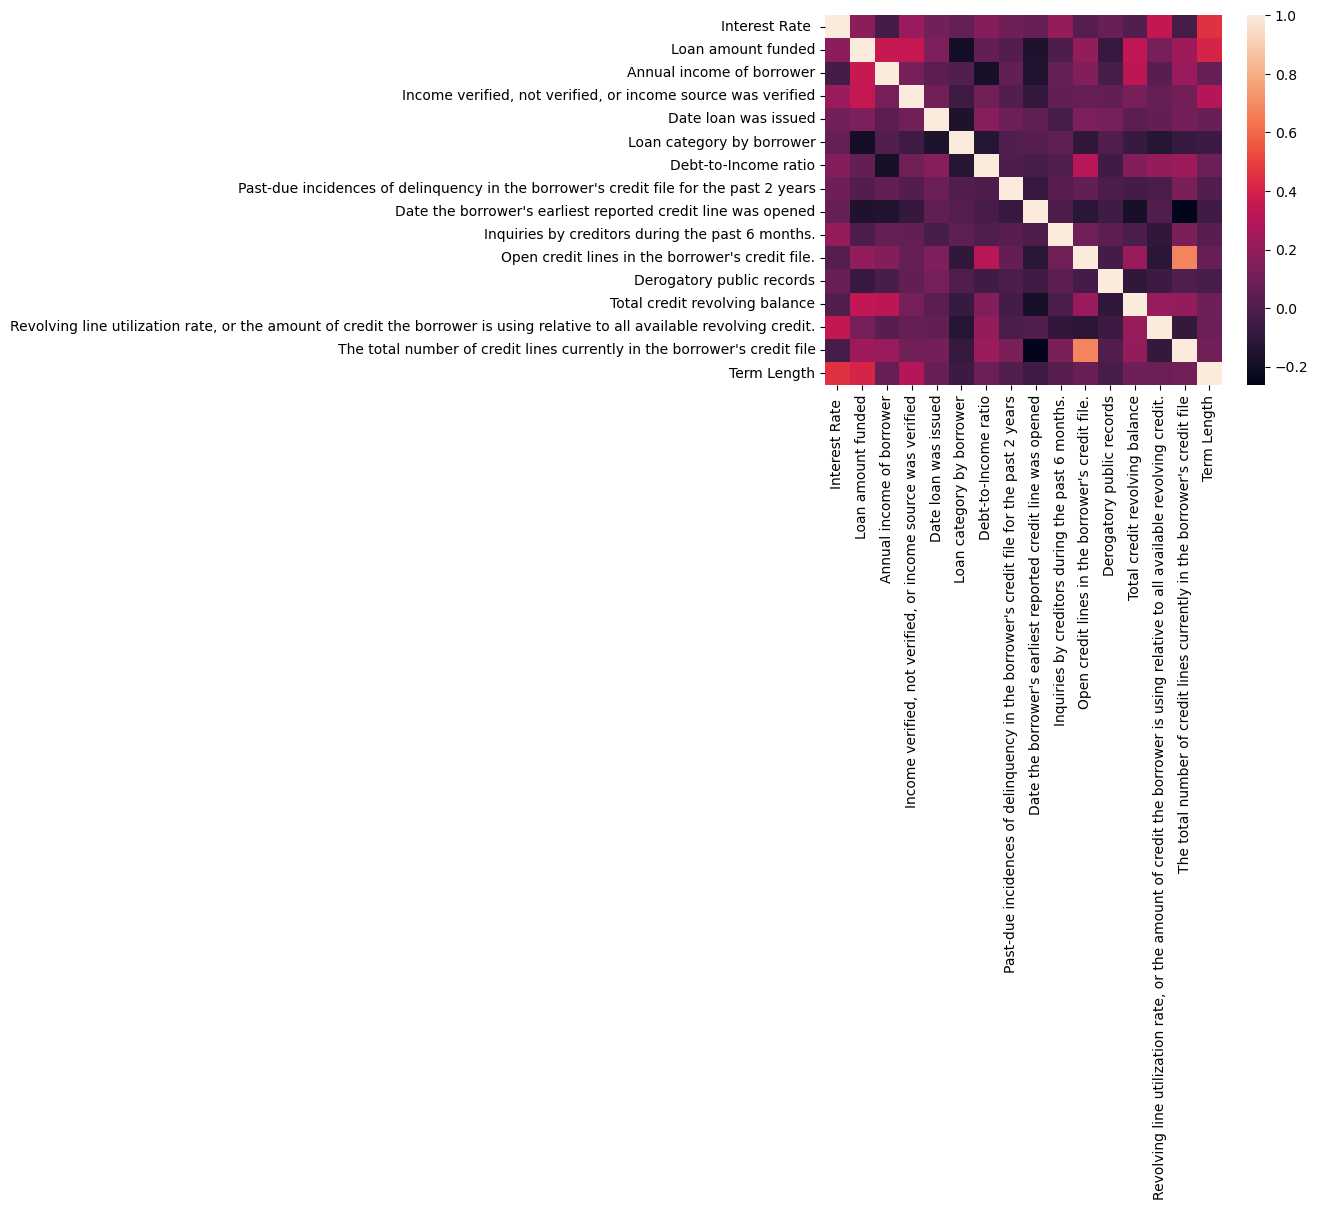

In [20]:
#Correlation of numerical values 
sns.heatmap(df.select_dtypes(exclude=['object']).corr())

## Imputing Missing Values 

In [21]:
#Imputing Missing Values for Home Ownership 
df['Home ownership status'].value_counts()

Home ownership status
MORTGAGE    172112
RENT        136778
OWN          29588
OTHER          124
NONE            36
ANY              1
Name: count, dtype: int64

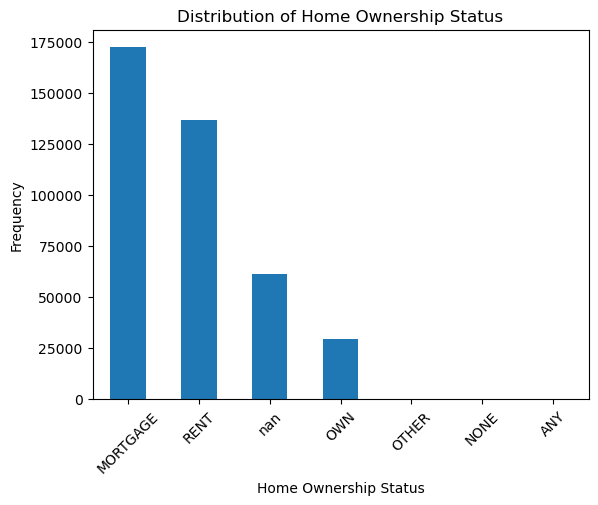

In [22]:
df['Home ownership status'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Home Ownership Status')
plt.xlabel('Home Ownership Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [23]:
df['Home ownership status'].fillna('ANY', inplace=True)
df['Home ownership status'] = df['Home ownership status'].replace(['OTHER', 'NONE'], 'ANY')

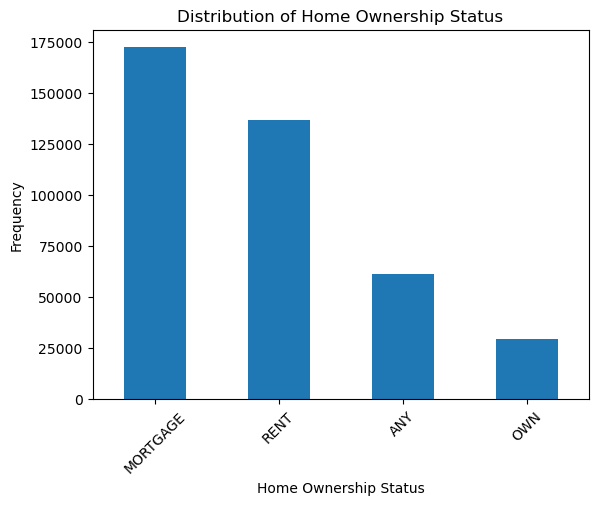

In [24]:
df['Home ownership status'].value_counts(dropna=False).plot(kind='bar')
plt.title('Distribution of Home Ownership Status')
plt.xlabel('Home Ownership Status')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [25]:
#Encoding Home Ownership Status 
df['Home ownership status'] = df['Home ownership status'].map({'MORTGAGE': 0, 'RENT': 1, 'ANY': 2, 'OWN': 3})

In [26]:
#Dropping na's from columns whose missing percentage is less than 7
df_clean = df.dropna(subset = ['Number of years employed (0 to 10; 10 = 10 or more)','Employer or job title (self-filled)','Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.', 'Loan title by borrower', 'The initial listing status of the loan. Possible values are ‰ÛÒ W, F', "Past-due incidences of delinquency in the borrower's credit file for the past 2 years", 'Total credit revolving balance', "The total number of credit lines currently in the borrower's credit file", 'Derogatory public records', "Open credit lines in the borrower's credit file.","Inquiries by creditors during the past 6 months.", 'First 3 numbers of zip code', "Date the borrower's earliest reported credit line was opened", 'Debt-to-Income ratio', 'State of borrower', 'Loan category by borrower', 'Date loan was issued', 'Income verified, not verified, or income source was verified', 'Loan amount funded','Term Length' ])

In [27]:
missing_values_table(df_clean)

Your selected dataframe has 24 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Loan grade,57442,15.3
Annual income of borrower,57378,15.3
Interest Rate,57215,15.2


In [28]:
# Converting Listing status to numerical value
df_clean['The initial listing status of the loan. Possible values are ‰ÛÒ W, F'] = df_clean['The initial listing status of the loan. Possible values are ‰ÛÒ W, F'].map({'f': 0, 'w': 1})

In [29]:
# Bucketing States of Borrower to regions

df_clean['State of borrower'] = df_clean['State of borrower'].map(
    {'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast',
    'NH': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'MI': 'Midwest', 'MN': 'Midwest',
    'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest',
    'OH': 'Midwest', 'SD': 'Midwest', 'WI': 'Midwest',
    
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South',
    'NC': 'South', 'SC': 'South', 'VA': 'South', 'DC': 'South',
    'WV': 'South', 'AL': 'South', 'KY': 'South', 'MS': 'South',
    'TN': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'TX': 'South',
    
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West',
    'NV': 'West', 'NM': 'West', 'UT': 'West', 'WY': 'West',
    'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West',
    'WA': 'West'})

In [30]:
df_clean['State of borrower'].unique()

array(['Northeast', 'South', 'West', 'Midwest'], dtype=object)

In [31]:
# Converting these states to numerical values
df_clean['State of borrower'] = df_clean['State of borrower'].map({'Northeast': 0, 'South': 1, 'West': 2, 'Midwest': 3})

In [32]:
df_clean['Number of years employed (0 to 10; 10 = 10 or more)'] = df_clean['Number of years employed (0 to 10; 10 = 10 or more)'].map({
    '< 1 year' : 0, '1 year': 1, '10+ years': 10,
    '6 years': 6, '9 years': 9, '3 years': 3,
    '5 years': 5, '2 years': 2, '4 years': 4,
    '8 years': 8, '7 years': 7
})

In [33]:
# Dropping 'Loan title by borrower', 'Job Title' and 'Zip Code'
df_clean.drop(['Employer or job title (self-filled)','First 3 numbers of zip code','Loan title by borrower' ], axis = 1, inplace = True)

In [34]:
# Dropping rows where all three columns have missing values 
df_clean = df_clean.dropna(subset=['Loan grade', 'Annual income of borrower', 'Interest Rate '], how='all')


In [35]:
missing_values_table(df_clean)

Your selected dataframe has 21 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
Loan grade,56086,15.0
Annual income of borrower,56022,15.0
Interest Rate,55859,14.9


In [36]:
# Making an Interaction between 'Date loan was issued and 'Date the borrower\'s earliest reported credit line was opened'
df_clean['Credit_duration'] = (df_clean['Date loan was issued'] - df_clean['Date the borrower\'s earliest reported credit line was opened']).dt.days / 365.25
df_clean['Credit_duration'] = df_clean['Credit_duration'].round()

In [37]:
# Dropping 'Date loan was issued' and 'Date the borrower\'s earliest reported credit line was opened'
df_clean.drop(["Date the borrower\'s earliest reported credit line was opened", 'Date loan was issued'], axis = 1 , inplace = True)

In [38]:
# Dropping all missing rows in Interest Rate
df_clean.dropna(subset=['Interest Rate '], inplace=True)

In [39]:
missing_values_table(df_clean)

Your selected dataframe has 20 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
Annual income of borrower,48654,15.3
Loan grade,48615,15.3


In [40]:
# Checking how many values are missing in both Annual Income and Loan grade 
missing_both = df[df['Annual income of borrower'].isna() & df['Loan grade'].isna()]
missing_both.shape[0]

9192

### Imputing Annual Income using MICE

In [41]:
# Making a new dataframe
df2 = df_clean.copy()
df2.drop('Loan grade' , axis = 1, inplace = True)

In [42]:
# Initialize the IterativeImputer
# Perform the imputation on the selected features
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)
features_imputed = iterative_imputer.fit_transform(df2)
df_clean['Annual income of borrower'] = features_imputed[:, 6] 

In [43]:
missing_values_table(df_clean)

Your selected dataframe has 20 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
Loan grade,48615,15.3


### Imputing Loan Grade using Classification 

In [44]:
df_clean['Loan grade'].unique()

array(['B', 'D', 'C', 'A', 'E', 'F', nan, 'G'], dtype=object)

In [45]:
df_clean['Loan grade'] = df_clean['Loan grade'].map({'A': 100, 'B': 80, 'C': 70, 'D': 60, 'E': 40, 'F': 30, 'G': 20})

In [46]:
df3 = df_clean.copy()
df3 = df3.dropna(subset = ['Loan grade'])

In [47]:
df4 = df_clean[df_clean['Loan grade'].isnull()]

In [48]:
df5 = df_clean.copy()
df5 = df5.dropna(subset=['Loan grade'])

In [49]:
train_x = df3.drop("Loan grade", axis=1)                             #All cloumns excluding loan grade
train_y = df5['Loan grade']                                          #Loan grade without any missing values
test_x = df4.drop(columns = ['Loan grade'], axis=1, inplace = False) #All features of missing Loan grade excluding Loan grade
test_y = df4['Loan grade']                                           #All missing value of Loan grade 

In [50]:
#Spltting dataframe in 80:20 ratio
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True)

In [51]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()

model.fit(train_x,train_y)

pred = model.predict(val_x)

In [52]:
from sklearn.metrics import accuracy_score

accuracy_score(val_y, pred)

0.9107741923526032

In [53]:
y_preds = model.predict(test_x)

In [54]:
df_clean.loc[df_clean['Loan grade'].isnull(), ['Loan grade']] = y_preds

### EDA

In [55]:
final_df = df_clean.copy()

In [56]:
final_df.corr()

,Interest Rate,Loan amount funded,Loan grade,Number of years employed (0 to 10; 10 = 10 or more),Home ownership status,Annual income of borrower,"Income verified, not verified, or income source was verified",Loan category by borrower,State of borrower,Debt-to-Income ratio,Past-due incidences of delinquency in the borrower's credit file for the past 2 years,Inquiries by creditors during the past 6 months.,Open credit lines in the borrower's credit file.,Derogatory public records,Total credit revolving balance,"Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.",The total number of credit lines currently in the borrower's credit file,"The initial listing status of the loan. Possible values are ‰ÛÒ W, F",Term Length,Credit_duration
Interest Rate,1.000000,0.183134,-0.950839,0.039635,0.037361,0.064382,0.227711,0.064382,-0.000039,0.158004,0.091650,0.211606,0.021862,0.072240,0.008610,0.341776,-0.025320,-0.011824,0.462728,-0.052706
Loan amount funded,0.183134,1.000000,-0.175606,0.120970,-0.105305,-0.192729,0.372302,-0.192729,-0.011858,0.065587,0.007141,-0.004368,0.198839,-0.072629,0.334446,0.119548,0.234358,0.056683,0.409331,0.193425
Loan grade,-0.950839,-0.175606,1.000000,-0.031395,-0.035985,-0.070879,-0.211481,-0.070879,0.002589,-0.142354,-0.092138,-0.201047,-0.018900,-0.074043,-0.006585,-0.317830,0.023639,0.001844,-0.465865,0.052432
Number of years employed (0 to 10; 10 = 10 or more),0.039635,0.120970,-0.031395,1.000000,-0.084592,-0.044094,0.066063,-0.044094,0.014021,0.052875,0.031572,-0.006498,0.044225,0.037358,0.093463,0.046953,0.117420,0.028144,0.084597,0.224098
Home ownership status,0.037361,-0.105305,-0.035985,-0.084592,1.000000,0.027352,-0.037961,0.027352,-0.045345,0.016785,-0.026754,-0.028471,-0.068254,0.001914,-0.075739,-0.021043,-0.115996,-0.005780,-0.059608,-0.072949
Annual income of borrower,0.064382,-0.192729,-0.070879,-0.044094,0.027352,1.000000,-0.054767,1.000000,-0.021948,-0.125647,0.006253,0.045224,-0.093225,0.000921,-0.075174,-0.132442,-0.076766,-0.060070,-0.061752,-0.050286
"Income verified, not verified, or income source was verified",0.227711,0.372302,-0.211481,0.066063,-0.037961,-0.054767,1.000000,-0.054767,-0.004179,0.107321,0.014090,0.058100,0.077690,0.056014,0.127108,0.074892,0.105895,0.015302,0.314479,0.095813
Loan category by borrower,0.064382,-0.192729,-0.070879,-0.044094,0.027352,1.000000,-0.054767,1.000000,-0.021948,-0.125647,0.006253,0.045224,-0.093225,0.000921,-0.075174,-0.132442,-0.076766,-0.060070,-0.061752,-0.050286
State of borrower,-0.000039,-0.011858,0.002589,0.014021,-0.045345,-0.021948,-0.004179,-0.021948,1.000000,0.032330,-0.013367,0.026701,-0.027739,0.035389,-0.013450,0.025081,0.003999,0.010292,-0.007446,0.006089
Debt-to-Income ratio,0.158004,0.065587,-0.142354,0.052875,0.016785,-0.125647,0.107321,-0.125647,0.032330,1.000000,-0.004227,0.000746,0.306525,-0.047513,0.149344,0.204865,0.230443,0.046794,0.089846,0.048437


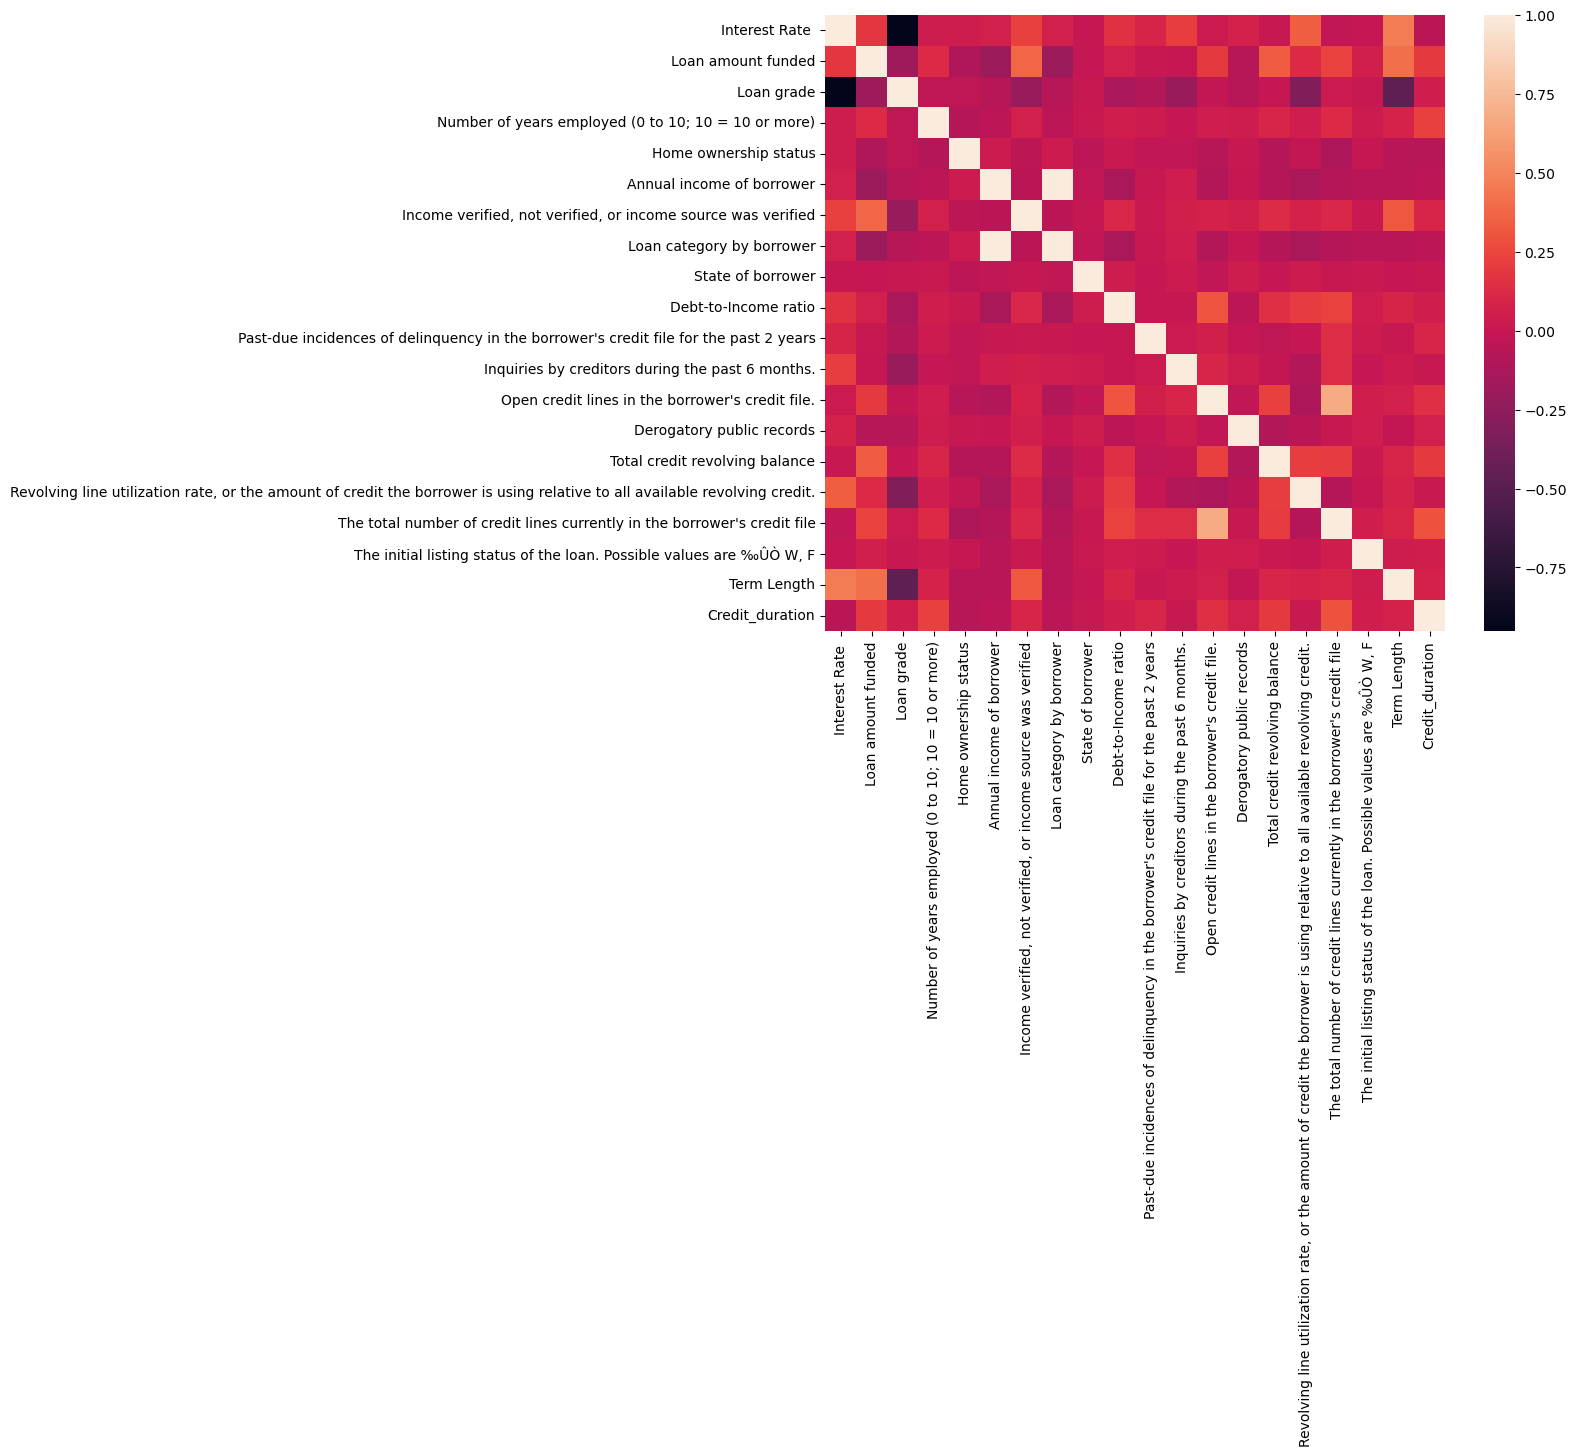

In [57]:
#Correlation Matrix
correlation_matrix = final_df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(correlation_matrix)
plt.show()

In [58]:
final_df.drop('Loan category by borrower', axis =1, inplace = True)

<Axes: xlabel='Interest Rate ', ylabel='Density'>

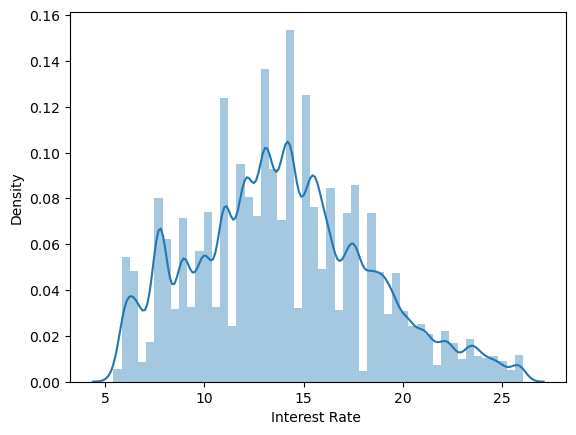

In [59]:
sns.distplot(final_df['Interest Rate '])

<Axes: xlabel='Loan grade', ylabel='Density'>

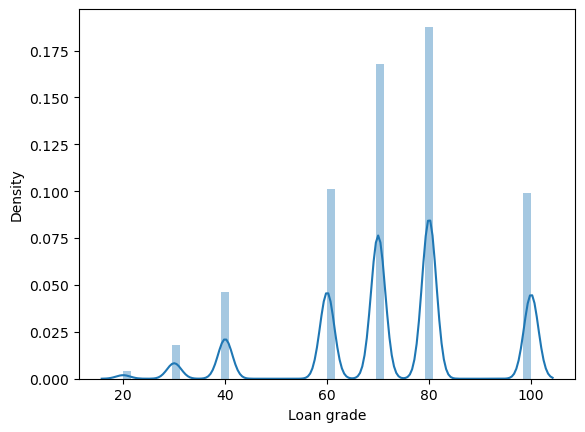

In [60]:
sns.distplot(final_df['Loan grade'])

### Modeling to Predict missing values in Interest Rate 

In [61]:
train_X = final_df.drop('Interest Rate ', axis = 1 )

In [62]:
train_Y = final_df['Interest Rate ']

In [63]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.2, shuffle=True)

### Random Forest

In [64]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42) 

rf_model.fit(train_X, train_Y)

y_pred = rf_model.predict(val_X)

In [65]:
# Calculate and print evaluation metrics for the validation set
mae = mean_absolute_error(val_Y, y_pred)
rmse = np.sqrt(mean_squared_error(val_Y, y_pred))
r2 = r2_score(val_Y, y_pred)

print(mae)
print(rmse)
print(r2)

<IPython.core.display.Javascript object>

0.9406222061687292
1.1799193363272857
0.9276153461462584


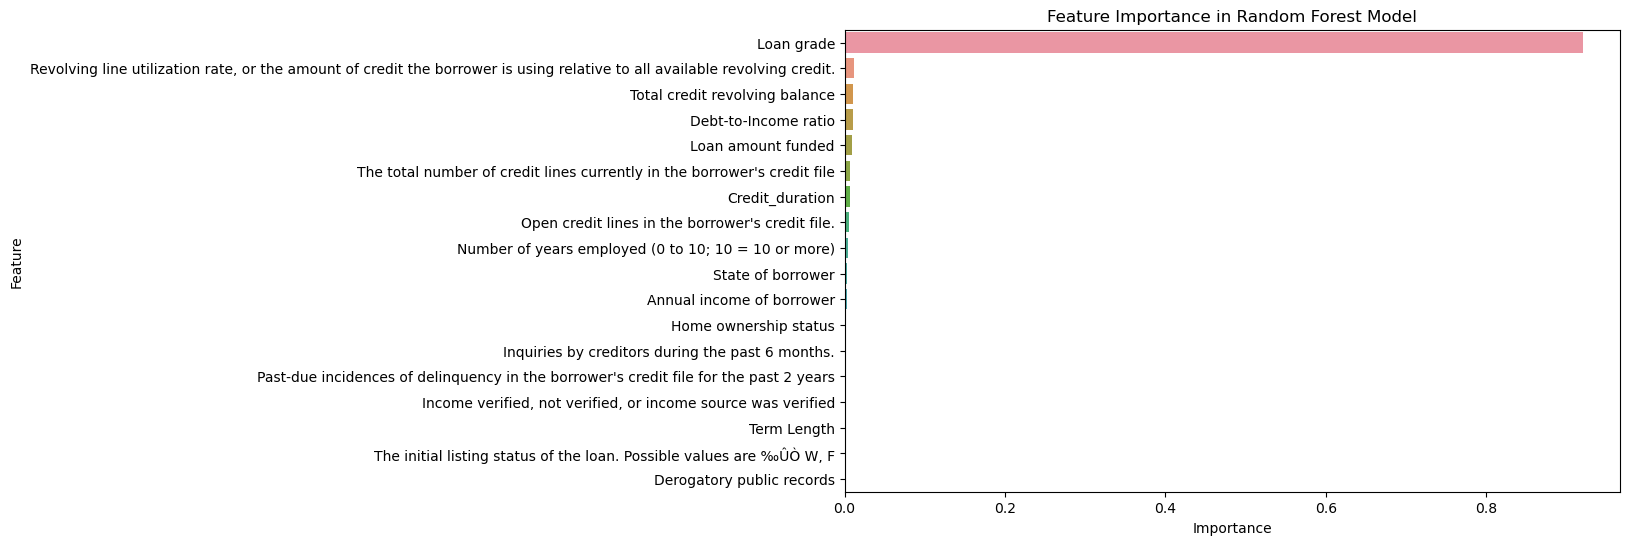

In [66]:
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame for easier plotting
feature_importances_df = pd.DataFrame({'Feature': train_X.columns, 'Importance': importances})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


### SGD Regressor

In [67]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()

sgd.fit(train_X,train_Y)

y_pred = sgd.predict(val_X)

In [68]:
# Calculate and print evaluation metrics for the validation set
mae = mean_absolute_error(val_Y, y_pred)
rmse = np.sqrt(mean_squared_error(val_Y, y_pred))
r2 = r2_score(val_Y, y_pred)

print(mae)
print(rmse)
print(r2)

<IPython.core.display.Javascript object>

2.6017596006630163e+17
4.624122345360272e+17
-1.1117330010035137e+34


### XG Boost

In [69]:
from xgboost import XGBRegressor

xgb = XGBRegressor()

xgb.fit(train_X,train_Y)

y_pred = xgb.predict(val_X)

In [70]:
# Calculate and print evaluation metrics for the validation set
mae = mean_absolute_error(val_Y, y_pred)
rmse = np.sqrt(mean_squared_error(val_Y, y_pred))
r2 = r2_score(val_Y, y_pred)

print(mae)
print(rmse)
print(r2)

<IPython.core.display.Javascript object>

0.9294815507666894
1.163952912915056
0.9295610800415266


### Random Forrest and XG Boost are giving us highest R2 and lowest RMSE
#### I have decided to move forward with Random Forrest

In [71]:
import joblib

# Assuming `model` is your trained model
model_filename = 'final_model.sav'
joblib.dump(rf_model, model_filename)

['final_model.sav']

## Testing with Holdout Dataset

In [72]:
holdout_df = pd.read_csv('Holdout for Testing.csv' , names = meta['Definition'])
holdout_df = holdout_df.iloc[1:]

### Pre-Processing Data

In [73]:
# Dropping Irrelevant Columns 
holdout_df.drop(['Loan subgrade', 'Unique id loan.','Borrower id', 'Loan category by borrower'], axis = 1, inplace = True)
holdout_df.drop(['Reason for loan by borrower', 'Employer or job title (self-filled)'], axis = 1, inplace = True)
holdout_df.drop(['Months since the last public record.', "Months since the borrower's last delinquency."], axis = 1, inplace = True)
holdout_df.drop(['Loan amount requested', "Investor-funded portion of loan"], axis = 1, inplace = True)
holdout_df.drop(['Loan title by borrower', 'First 3 numbers of zip code' ], axis = 1, inplace = True)

In [74]:
# Converting Datatype
holdout_df['Interest Rate '] = holdout_df['Interest Rate '].astype('float')
holdout_df['Loan amount funded'] = holdout_df['Loan amount funded'].str.replace('$','').str.replace(',','').astype('float')
holdout_df['Annual income of borrower'] = holdout_df['Annual income of borrower'].astype(float)
holdout_df['Debt-to-Income ratio'] = holdout_df['Debt-to-Income ratio'].astype('float')
holdout_df['Past-due incidences of delinquency in the borrower\'s credit file for the past 2 years'] = holdout_df['Past-due incidences of delinquency in the borrower\'s credit file for the past 2 years'].astype('float')
holdout_df['Inquiries by creditors during the past 6 months.'] = holdout_df['Inquiries by creditors during the past 6 months.'].astype('float')
holdout_df["Open credit lines in the borrower's credit file."] = holdout_df["Open credit lines in the borrower's credit file."].astype('float')
holdout_df['Derogatory public records'] = holdout_df['Derogatory public records'].astype('float')
holdout_df['Total credit revolving balance'] = holdout_df['Total credit revolving balance'].astype('float')
holdout_df["Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."] = holdout_df["Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."].str.replace('%','').str.replace(',','').astype('float')
holdout_df['The total number of credit lines currently in the borrower\'s credit file'] = holdout_df['The total number of credit lines currently in the borrower\'s credit file'].astype('float')
holdout_df['Date loan was issued'] = pd.to_datetime(holdout_df['Date loan was issued'], format='%y-%b')


In [75]:
# Mapping States to regions
holdout_df['State of borrower'] = holdout_df['State of borrower'].map(
    {'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast',
    'NH': 'Northeast', 'RI': 'Northeast', 'VT': 'Northeast',
    'NJ': 'Northeast', 'NY': 'Northeast', 'PA': 'Northeast',
    
    'IL': 'Midwest', 'IN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'MI': 'Midwest', 'MN': 'Midwest',
    'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest',
    'OH': 'Midwest', 'SD': 'Midwest', 'WI': 'Midwest',
    
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South',
    'NC': 'South', 'SC': 'South', 'VA': 'South', 'DC': 'South',
    'WV': 'South', 'AL': 'South', 'KY': 'South', 'MS': 'South',
    'TN': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'TX': 'South',
    
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West',
    'NV': 'West', 'NM': 'West', 'UT': 'West', 'WY': 'West',
    'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West',
    'WA': 'West'})

In [76]:
# Converting categorical features to numerical 
holdout_df['Term Length'] = holdout_df['Number of payments (36 or 60)'].map({' 36 months': 0, ' 60 months': 1 }) 
holdout_df.drop('Number of payments (36 or 60)', axis=1, inplace = True)
holdout_df['Income verified, not verified, or income source was verified'] = holdout_df['Income verified, not verified, or income source was verified'].map({'VERIFIED - income': 5 , 'not verified': 0 , 'VERIFIED - income source': 5})
holdout_df['Loan grade'] = holdout_df['Loan grade'].map({'A': 100, 'B': 80, 'C': 70, 'D': 60, 'E': 40, 'F': 30, 'G': 20})
holdout_df['Number of years employed (0 to 10; 10 = 10 or more)'] = holdout_df['Number of years employed (0 to 10; 10 = 10 or more)'].map({'< 1 year' : 0, '1 year': 1, '10+ years': 10,'6 years': 6, '9 years': 9, '3 years': 3,'5 years': 5, '2 years': 2, '4 years': 4,'8 years': 8, '7 years': 7})
holdout_df['Home ownership status'] = holdout_df['Home ownership status'].map({'MORTGAGE': 0, 'RENT': 1, 'ANY': 2, 'OWN': 3})
holdout_df['State of borrower'] = holdout_df['State of borrower'].map({'Northeast': 0, 'South': 1, 'West': 2, 'Midwest': 3})
holdout_df['The initial listing status of the loan. Possible values are ‰ÛÒ W, F'] = holdout_df['The initial listing status of the loan. Possible values are ‰ÛÒ W, F'].map({'f': 0, 'w': 1})

In [77]:
from datetime import datetime
import pandas as pd
import re

def adjust_year(year):
    if 1 <= year <= 12:
        return 2000 + year
    elif year == 0:
        return 2000
    elif year >= 68:
        return 1900 + year
    else:
        return 2000 + year

def convert_date(date_str):
    # Attempt to extract the year and month parts from the date string
    match = re.match(r"(\w{3})-(\d{2}|\d)$", date_str)
    if match:
        month, year = match.groups()
        year = int(year)
        year = adjust_year(year)
        # Reconstruct the date string with adjusted year
        date_str = f"{month}-{year}"
    else:
        match = re.match(r"(\d{1,2})-(\w{3})$", date_str)
        if match:
            year, month = match.groups()
            year = int(year)
            year = adjust_year(year)
            date_str = f"{month}-{year}"
        else:
            # If the format does not match expected patterns, return None
            return None

    try:
        # Now, parse the adjusted date string
        date_obj = datetime.strptime(date_str, "%b-%Y")
        return date_obj
    except ValueError:
        # Log or handle dates that can't be parsed
        print(f"Failed to parse: {date_str}")
        return None


# Apply convert_date to each row in the specific column
holdout_df['Converted Date'] = holdout_df['Date the borrower\'s earliest reported credit line was opened'].apply(convert_date)

In [78]:
def correct_future_dates(date_obj):
    # Get the current year
    current_year = datetime.now().year
    
    # If the year of the date object is in the future, adjust it to the 1900s
    if date_obj.year > current_year:
        # Calculate the correct year by subtracting 100 years
        corrected_year = date_obj.year - 100
        # Replace the year in the date object
        date_obj = date_obj.replace(year=corrected_year)
        
    return date_obj

In [79]:
holdout_df['Converted Date'] = holdout_df['Converted Date'].apply(correct_future_dates)

In [80]:
holdout_df['Credit_duration'] = (holdout_df['Date loan was issued'] - holdout_df['Converted Date']).dt.days / 365.25
holdout_df['Credit_duration'] = holdout_df['Credit_duration'].round()
holdout_df.drop(["Date the borrower\'s earliest reported credit line was opened",'Converted Date', 'Date loan was issued'], axis = 1 , inplace = True)

In [81]:
#imputing missing values 
mode_value = holdout_df['Number of years employed (0 to 10; 10 = 10 or more)'].mode()[0]
holdout_df['Number of years employed (0 to 10; 10 = 10 or more)'].fillna(mode_value, inplace=True)

mean_value = holdout_df['Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.'].mean()
holdout_df['Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.'].fillna(mean_value, inplace=True)

## Fitting Model 

In [82]:
X_holdout = holdout_df.iloc[:, 1:]
predictions = rf_model.predict(X_holdout)
predictions_df = pd.DataFrame(predictions, columns=['Predicted Interest Rate'])
predictions_df.to_csv('Results_from_achintya.csv', index=False)

### Techniques Used and Why

#### Data-Preprocessing 

1. MICE for imputation: It creates multiple imputations, can provide a more accurate estimate of the missing values and preserve the relationships among variables.It uses the entire set of observed data points to estimate the missing values and can accurately impute missing data even when the patterns of missingness are complicated.

2. Imputation of missing loan grade using classification techniques: Used Random Forrest to predict the missing values, instead of dropping valuable data. As It can handle categorical and numerical data and does not require scaling of data.

#### Modeling 

1. Random Forrest Regressor: It operates by constructing decision trees at training time and outputting the mean prediction of the individual trees. It can handle a wide range of data types and is robust to outliers and non-linear data

2. SGD Regressor: It uses stochastic gradient descent for optimization. It's particularly useful for large-scale and high-dimensional data due to its efficiency and simplicity.

3. XG Boost: It is designed to be highly efficient, scalable, and fast. It utilizes advanced techniques such as tree pruning and hardware optimization to ensure quick execution.It has an in-built routine to perform cross-validation at each iteration of the boosting process, making it easy to obtain accurate estimates.